# Homework 2 feedback

## 1. Simple passive cable cable


### 1.

* Time constant: $\tau = C_m R_m = C_m/G_m =$ 20 ms.
* Space constant: $\lambda = (r_m/r_a)^{1/2} = \left( \frac{R_m}{\pi d} \cdot {\left(\frac{4 R_a}{\pi d^2}\right)}^{-1} \right)^{1/2} = \left( \frac{d}{4 R_i G_m}\right)^{1/2}$ ≈ 577 μm.

### 2.
The measured $\tau$ should be close to 20 ms.


### 3. 

The measured $\lambda$ should be close to 577 μm but can be larger since this is a finite cable whose length is close to the theoretical $\lambda$ and the cable has sealed ends.
|
### 4. 

The cable end is more depolarized as the cable gets shorter since the current escape through the membrane becomes smaller. In the open end case, the opposite is true since the current sink becomes closer to the current source as the cable gets shorter. Therefore, the axon has sealed ends. Another way is to find the boundary condition is that $dV/dX$ ≈ 0 in the simulated data. 

## 2. Voltage signal filtering in a passive pyramidal neuron

The following is an example code to generate simulation data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import r18_1

h.xopen("iclamp.ses")


def run(tstop=200):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(h.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.c() # Should return a copy of the vector


Inserting passive membrane properties

Initializing uniform passive membrane properties



Now we record the maximum depolarization due to a sustained (`h.IClamp[0].dur`=150 ms) current injection, depending on electrode location.

In [2]:
# Reset lists
vrecs = []
distances = []

In [17]:
vrecs.append(run())
# r18_1.distance_from_soma(ic) computes a distance from a soma 
# to the current clamp electrode
distances.append(r18_1.distance_from_soma(h.IClamp[0]))

print("Number of simulations ran =", len(distances))

Number of simulations ran = 15


In [24]:
dist_150 = distances
v_150 = [v.max()+76 for v in vrecs]

We do the same with a short (`h.IClamp[0].dur`=2.5 ms) current injection.

In [28]:
# Change the injection duration
h.IClamp[0].dur = 2.5

# Reset lists
vrecs = []
distances = []

In [41]:
vrecs.append(run())
# r18_1.distance_from_soma(ic) computes a distance from a soma 
# to the current clamp electrode
distances.append(r18_1.distance_from_soma(h.IClamp[0]))

print("Number of simulations ran =", len(distances))

Number of simulations ran = 13


In [45]:
dist_2_5 = distances
v_2_5 = [v.max()+76 for v in vrecs]

We also compute the normalized depolarization, normalized by the voltage change due to a injection at soma.

In [47]:
nv_150 = [v/v_150[0] for v in v_150]
nv_2_5 = [v/v_2_5[0] for v in v_2_5]

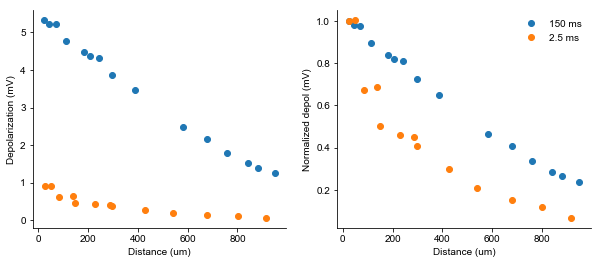

In [55]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(dist_150, v_150, 'o', dist_2_5, v_2_5, 'o')
ax[0].set(xlabel="Distance (um)", ylabel="Depolarization (mV)")
ax[1].plot(dist_150, nv_150, 'o', dist_2_5, nv_2_5, 'o')
ax[1].set(xlabel="Distance (um)", ylabel="Normalized depol (mV)")
ax[1].legend(("150 ms", "2.5 ms"))


We can see that the normalized depolarization drops more quickly around the soma, due to the filtering effect by dendritic branching.

## 3. Synaptic scaling

### 1. 
Along an apical dendrite, `gmax` required to achieve an ~0.2 mV EPSP at soma grows nonlinearly as the following figure.

![](hw21.png)

Compared with the case when `gmax` is held constant (0.1 nS), the synaptic conductance needs to be scaled to achieve EPSP ~ 0.2 mV as the following figure. Note that the scaling factor deviates from ~1/EPSP, and therefore  `gmax` should be larger than a prediction that EPSP grows linearly with `gmax`. The effect is more pronounced in a distal dendrite, since the membrane potential is more depolarized with a synaptic input and therefore the synaptic current decreases --- a paradoxical effect that higher *local* depolarization due to a synaptic input causes less driving force for somatic excitation.

![](hw22.png)



### 2. 

If you probe dendrites very far from a soma in a tuft, an AMPA synapse can be **impossible to cause a ~2 mV EPSP**. In those dendrites, even when `gmax` is sufficiently large to make the membrane potential reach a reversal potential (0 mV, blue), the EPSP at soma is only ~ 0.25 mV (black). 

![](hw23.png)

If you have not found this, which means that you did no go very far, the result here should be compatible with 1.




## 4.  Summation of excitatory synaptic inputs

The following is the example code for this question


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import r18_1

h.xopen("two_syns.ses")

# Set up external stimuli to trigger excitatory synapses

stims = []
ncs = []
for i in range(2):
    stims.append(h.NetStim())
    stims[-1].start = 50
    stims[-1].number = 1
    stims[-1].noise = 0

    ncs.append(h.NetCon(stims[-1], h.Exp2Syn[i]))
    ncs[-1].weight[-1] = 0.01




Inserting passive membrane properties

Initializing uniform passive membrane properties



In [18]:
dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval

def run(tstop=200):
    
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(h.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    vrec = vrec.c().to_python() # Make the NEURON vector to a Python list
    vrec = np.array(vrec)       # Make the list into a NumPy array
    vrec = vrec + 76            # Subtract the resting membrane potential
    return 


def run_whole_sim():
    
    # Reset all the conductance for synaptic connections to 10 nS
    for nc in ncs:
        nc.weight[0] = 0.01

    v_total = run() # EPSP with two stimuli
    
    # Turn off synaptic connection 1.
    ncs[1].weight[0] = 0
    
    v_only_1 = run()
    
    # Now turn off synaptic connection 2 while turning on connection 2
    ncs[0].weight[0] = 0
    ncs[1].weight[0] = 0.01
    
    v_only_2 = run()
    
    return v_total, v_only_1, v_only_2


[Text(0,0.5,'EPSP (mV)'), Text(0.5,0,'Time (ms)')]

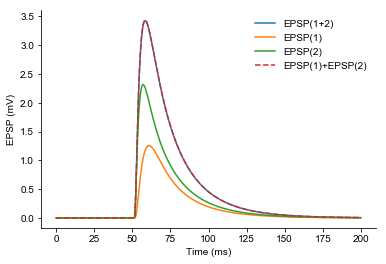

In [24]:
dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval

# We first run the case when two synapses are on different branches

v0, v1, v2 = run_whole_sim()

t = np.arange(v0.size)*dt

fig, ax = plt.subplots()
ax.plot(t, v0, t, v1, t, v2, t, v1+v2, '--')
ax.legend(('EPSP(1+2)', 'EPSP(1)', 'EPSP(2)', 'EPSP(1)+EPSP(2)'))
ax.set(xlabel='Time (ms)', ylabel='EPSP (mV)')

[Text(0,0.5,'EPSP (mV)'), Text(0.5,0,'Time (ms)')]

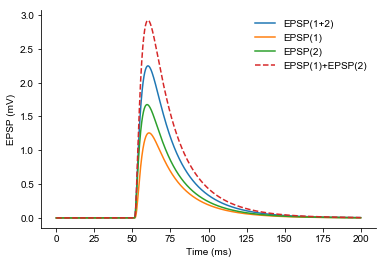

In [25]:
v0, v1, v2 = run_whole_sim()

# Now we run the case when two synapses are on the same branch

t = np.arange(v0.size)*dt

fig, ax = plt.subplots()
ax.plot(t, v0, t, v1, t, v2, t, v1+v2, '--')
ax.legend(('EPSP(1+2)', 'EPSP(1)', 'EPSP(2)', 'EPSP(1)+EPSP(2)'))
ax.set(xlabel='Time (ms)', ylabel='EPSP (mV)')

Here we see a sublinear summation effect.

## 5.  Summation of excitatory and inhibitory synaptic inputs 

### 1, 2, 3

The following is the example code:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import r18_1

h.xopen("two_syns.ses")

stims = []
ncs = []
for i in range(2):
    stims.append(h.NetStim())
    stims[-1].start = 50
    stims[-1].number = 1
    stims[-1].noise = 0

    ncs.append(h.NetCon(stims[-1], h.Exp2Syn[i]))
    ncs[-1].weight[-1] = 0.01

# Here we use an adaptive integrator to speed up the simulation
cv = h.CVode()
cv.active(1)
    

Inserting passive membrane properties

Initializing uniform passive membrane properties



1.0

In [3]:
h.Exp2Syn[1].e = -76
h.Exp2Syn[1].tau2 = 100
stims[1].start = 0

In [14]:
dt = 0.1
def run(tstop=200):
    
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(h.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.max()+76


# Here we run simulations for a given excitatory conductance
gEsyns = 10**np.arange(-6, 10.1, 1)

def run_one_batch():
    epsps = []
    for gsyn in gEsyns:
        ncs[0].weight[0] = gsyn
        epsps.append(run())
    return epsps


In [34]:
# And also we change the inhibitory conductance as well
# when the inhibitory synapse is at the proximal part,
gIsyns = np.arange(0, 0.01, 0.002)

epsps = []
for gsyn in gIsyns:
    print('gIsyn =', gsyn)
    ncs[1].weight[0] = gsyn
    epsps.append(run_one_batch())

epsp_prox = epsps

gIsyn = 0.0
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.002
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.004
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.006
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.008
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed 

In [33]:
# ... and when the inhibitory synapse is very close to the excitatory synapse,

epsps = []
for gsyn in gIsyns:
    print('gIsyn =', gsyn)
    ncs[1].weight[0] = gsyn
    epsps.append(run_one_batch())

epsp_dist = epsps

gIsyn = 0.0
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.002
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.004
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.006
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.008
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed 

In [35]:
# ... and when the inhibitory synapse is on a different branch.

epsps = []
for gsyn in gIsyns:
    print('gIsyn =', gsyn)
    ncs[1].weight[0] = gsyn
    epsps.append(run_one_batch())

epsp_diff = epsps

gIsyn = 0.0
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.002
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.004
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.006
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
gIsyn = 0.008
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed 

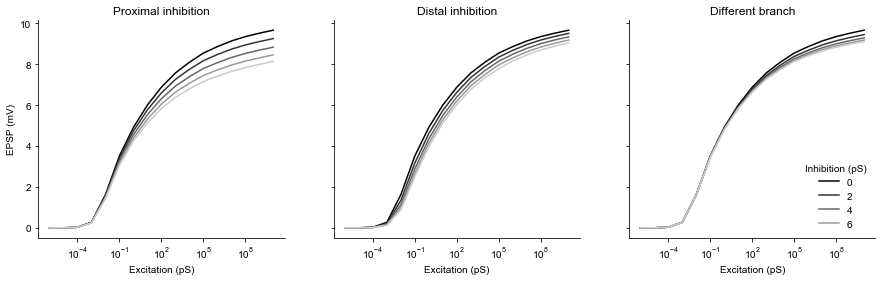

In [38]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), sharey=True)

for i, _ in enumerate(epsp_prox):
    ax[0].semilogx(gEsyns, epsp_prox[i], color=[0.2*i]*3)
    ax[1].semilogx(gEsyns, epsp_dist[i], color=[0.2*i]*3)
    ax[2].semilogx(gEsyns, epsp_diff[i], color=[0.2*i]*3)
    ax[2].legend(('0', '2', '4', '6'), loc=4, frameon=False, title='Inhibition (pS)')
    ax[0].set(xlabel='Excitation (pS)', ylabel='EPSP (mV)', title='Proximal inhibition')
    ax[1].set(xlabel='Excitation (pS)', title='Distal inhibition')
    ax[2].set(xlabel='Excitation (pS)', title='Different branch')

As in the textbook, what the proximal inhibition case shows is called "divisive inhibition" whereas the distal case is called "subtractive inhibition." It is tempting to conclude that PV neurons perform divisive inhibition while SOM neurons do subtraction on the pyramidal cell's output, but here we have looked into only the membrane potential, not the spike output, which is a non-trivial problem.